In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
import geoplot.crs as ccrs
import geoplot as gplt
%matplotlib inline

# Load Data

In [71]:
# Boroughs
boroughs = gpd.read_file("../data/nyc_boroughs/boroughs.geojson", driver='GeoJSON')
boroughs['Population'] = [378, 1951, 2300, 1487, 1203]
boroughs['Population Density'] = boroughs['Population'] / boroughs['Shape_Area']
boroughs = boroughs.set_index('BoroName')
boroughs.index = [b.upper() for b in boroughs.index]

# Collisions
collisions = pd.read_csv("../data/nyc_collisions/NYPD_Motor_Vehicle_Collisions_2016.csv")
collisions = collisions[collisions['BOROUGH'].notnull()]

fatal_collisions = collisions[collisions["NUMBER OF PERSONS KILLED"] > 0]
injurious_collisions = collisions[collisions["NUMBER OF PERSONS INJURED"] > 0]

def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return Point(0, 0)
    else:
        return Point(long, lat)

fatal_collisions = gpd.GeoDataFrame(fatal_collisions, 
                                    geometry=fatal_collisions.apply(pointify, axis='columns'))
fatal_collisions = fatal_collisions[fatal_collisions.geometry.map(lambda srs: not (srs.x == 0))]
fatal_collisions = fatal_collisions[fatal_collisions['DATE'].map(lambda day: "2016" in day)]

injurious_collisions = gpd.GeoDataFrame(injurious_collisions, 
                                        geometry=injurious_collisions.apply(pointify, axis='columns'))
injurious_collisions = injurious_collisions[injurious_collisions.geometry.map(lambda srs: not (srs.x == 0))]
injurious_collisions = injurious_collisions[injurious_collisions['DATE'].map(lambda day: "2016" in day)]



# # Citibike (Network)
# citibike = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/citibike-sankey/master/data/linesegments.csv", index_col=0)
# def geometries(srs):
#     start = Point(srs['Start Y'], srs['Start X'])
#     end = Point(srs['End Y'], srs['End X'])
#     return pd.Series({'From': start, 'To': end})
# to_and_from = citibike.sample(1000).apply(geometries, axis='columns')

# # Cities
# cities = gpd.read_file("../data/cities/citiesx010g.shp")
# cities = cities[cities['STATE'].map(lambda s: s not in ['PR', 'AK', 'HI', 'VI'])]

# # Census Tracts
# census_tracts = gpd.read_file("../data/nyc_census_tracts/census_tracts_2010.geojson", driver='GeoJSON')
# from random import randint
# census_tracts['mock_data'] = [randint(10, 1000) for _ in range(len(census_tracts))]

26222


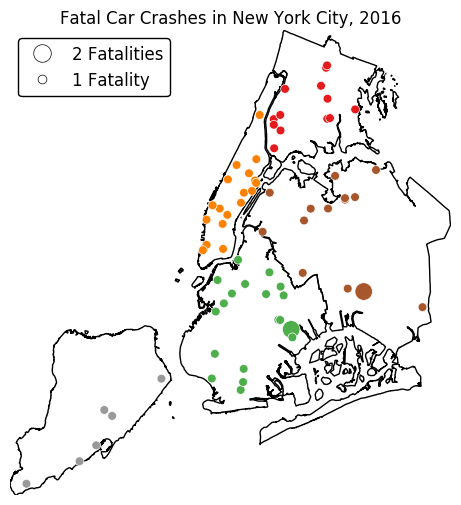

In [45]:
ax = gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea())
gplt.pointplot(fatal_collisions, projection=ccrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS KILLED', limits=(2, 8), 
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[2, 1], legend_labels=['2 Fatalities', '1 Fatality'],
               ax=ax)
plt.title("Fatal Car Crashes in New York City, 2016")

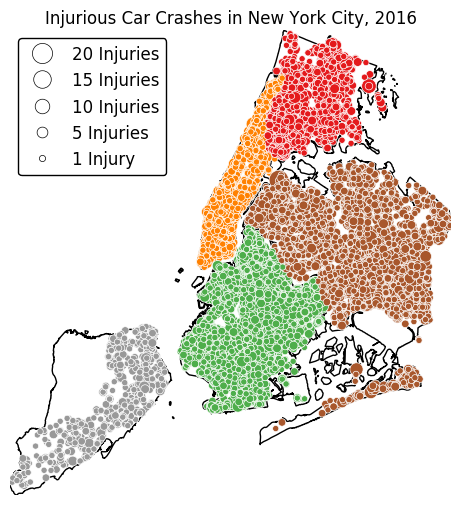

In [74]:
ax = gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea())
gplt.pointplot(injurious_collisions, projection=ccrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS INJURED', limits=(1, 10), 
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[20, 15, 10, 5, 1],
               legend_labels=['20 Injuries', '15 Injuries', '10 Injuries', '5 Injuries', '1 Injury'],
               ax=ax)
plt.title("Injurious Car Crashes in New York City, 2016")

In [78]:
import cartopy.crs as tcrs

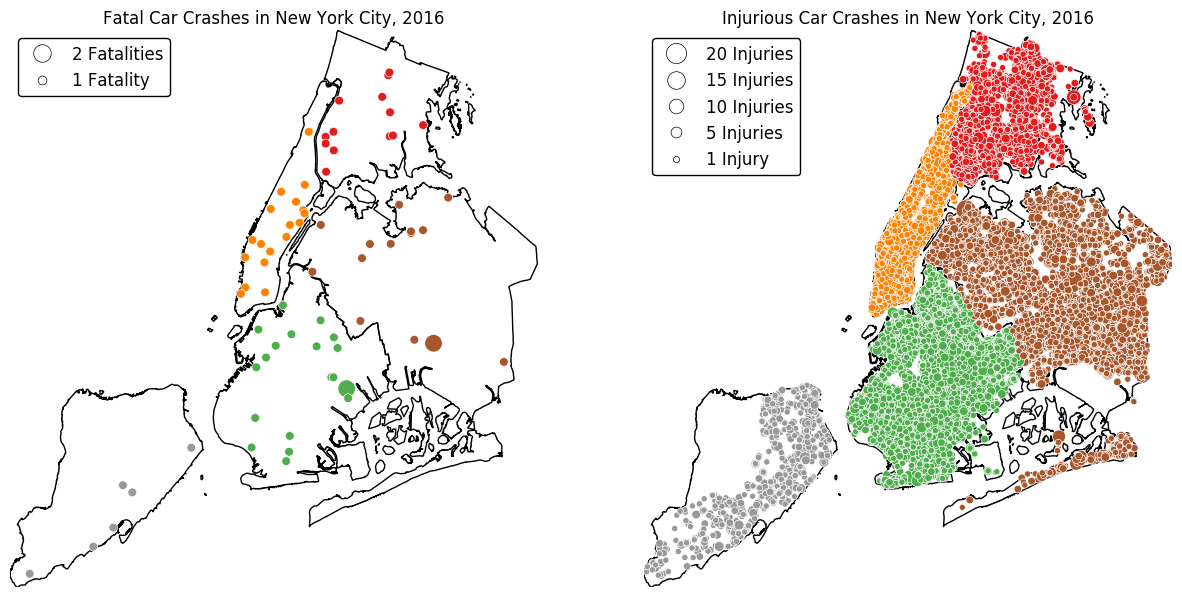

In [115]:
fig = plt.figure(figsize=(15,12))
ax = plt.subplot(121, projection=ccrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))
gplt.polyplot(boroughs, ax=ax, projection=ccrs.AlbersEqualArea())
gplt.pointplot(fatal_collisions, projection=ccrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS KILLED', limits=(2, 8), 
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[2, 1], legend_labels=['2 Fatalities', '1 Fatality'],
               ax=ax)
plt.title("Fatal Car Crashes in New York City, 2016")

ax = plt.subplot(122, projection=ccrs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059))
gplt.polyplot(boroughs, ax=ax, projection=ccrs.AlbersEqualArea())
gplt.pointplot(injurious_collisions, projection=ccrs.AlbersEqualArea(),
               hue='BOROUGH', categorical=True,
               edgecolor='white', linewidth=0.5, zorder=10,
               scale='NUMBER OF PERSONS INJURED', limits=(1, 10), 
               legend=True, legend_var='scale', legend_kwargs={'loc': 'upper left'},
               legend_values=[20, 15, 10, 5, 1],
               legend_labels=['20 Injuries', '15 Injuries', '10 Injuries', '5 Injuries', '1 Injury'],
               ax=ax)
plt.title("Injurious Car Crashes in New York City, 2016")

In [211]:
cities = gpd.read_file("../data/cities/citiesx010g.shp")
continental_cities = cities[cities['STATE'].map(lambda s: s not in ['PR', 'AK', 'HI', 'VI'])]
continental_cities = continental_cities[continental_cities['POP_2010'] > 100000]

usa = gpd.read_file("../data/united_states/usa.geojson")
continental_usa = usa[~usa['adm1_code'].isin(['USA-3517', 'USA-3563'])]

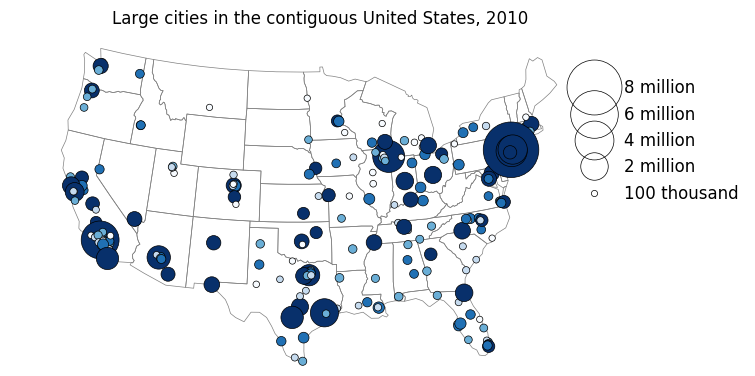

In [256]:
poly_kwargs = {'linewidth': 0.5, 'edgecolor': 'gray', 'zorder': -1}
point_kwargs = {'linewidth': 0.5, 'edgecolor': 'black', 'alpha': 1}
legend_kwargs = {'bbox_to_anchor': (1.2, 0.9), 'frameon': False}

ax = gplt.polyplot(continental_usa,
                   projection=ccrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
                   **poly_kwargs)
ax.set_ylim((-1597757.3894385984, 1457718.4893930717))
gplt.pointplot(continental_cities, projection=ccrs.AlbersEqualArea(), ax=ax,
               scale='POP_2010', limits=(1, 80),
               hue='POP_2010', cmap='Blues',
               legend=True, legend_var='scale',
               legend_values=[8000000, 6000000, 4000000, 2000000, 100000],
               legend_labels=['8 million', '6 million', '4 million', '2 million', '100 thousand'],
               legend_kwargs=legend_kwargs,
               **point_kwargs)
plt.title("Large cities in the contiguous United States, 2010")
plt.savefig("test.png", bbox_inches='tight', pad_inches=0.1)

> /Users/Honors/Desktop/geoplot/geoplot/geoplot.py(335)pointplot()
-> sorted_indices = np.array(sorted(enumerate(sizes), key=lambda tup: tup[1])[::-1])[:,0].astype(int)
(Pdb) c


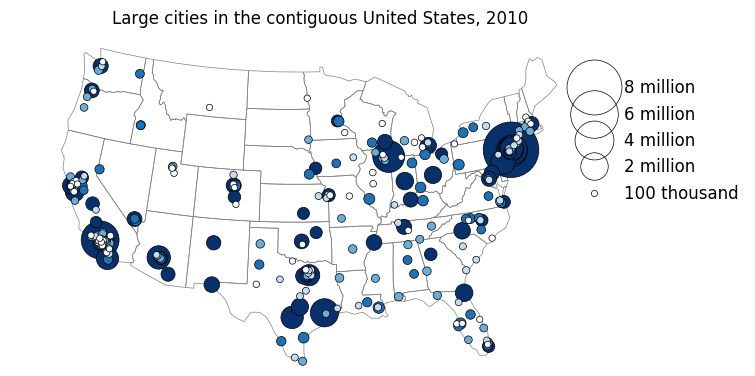

In [274]:
poly_kwargs = {'linewidth': 0.5, 'edgecolor': 'gray', 'zorder': -1}
point_kwargs = {'linewidth': 0.5, 'edgecolor': 'black', 'alpha': 1}
legend_kwargs = {'bbox_to_anchor': (1.2, 0.9), 'frameon': False}

ax = gplt.polyplot(continental_usa,
                   projection=ccrs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5),
                   **poly_kwargs)
ax.set_ylim((-1597757.3894385984, 1457718.4893930717))
gplt.pointplot(continental_cities, projection=ccrs.AlbersEqualArea(), ax=ax,
               scale='POP_2010', limits=(1, 80),
               hue='POP_2010', cmap='Blues',
               legend=True, legend_var='scale',
               legend_values=[8000000, 6000000, 4000000, 2000000, 100000],
               legend_labels=['8 million', '6 million', '4 million', '2 million', '100 thousand'],
               legend_kwargs=legend_kwargs,
               **point_kwargs)
plt.title("Large cities in the contiguous United States, 2010")
plt.savefig("test.png", bbox_inches='tight', pad_inches=0.1)

In [2]:
troop_positions = pd.read_fwf("../data/napoloen/troops.txt")
troop_positions = gpd.GeoDataFrame(data=troop_positions,
                                   geometry=troop_positions\
                                       .apply(lambda srs: Point(srs['long'], srs['lat']), 
                                              axis='columns'))

In [3]:
subsrs = []
for a, b in zip(range(len(troop_positions) - 1), range(1, len(troop_positions))):
    srs = troop_positions.iloc[b]
    srs = srs.rename({'geometry': 'from'})
    srs['to'] = troop_positions.iloc[a].geometry
    subsrs.append(srs)
troop_movements = pd.concat(subsrs, axis=1).T
troop_movements = troop_movements[['survivors', 'direction', 'group', 'from', 'to']]
troop_movements['direction'] = troop_movements.direction.map(lambda d: 0 if d == 'A' else 1)

In [8]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(215/255, 193/255, 126/255), (37/255, 37/255, 37/255)]
cm = LinearSegmentedColormap.from_list('minard', colors)


gplt.sankey(troop_movements, start='from', end='to', 
            scale='survivors', limits=(0.5, 45),
            hue='direction', categorical=True, cmap=cm)
import mplleaflet; mplleaflet.show()

In [19]:
%debug

> /Users/Honors/Desktop/geoplot/geoplot/geoplot.py(2490)_validate_buckets()
   2488     """
   2489     if categorical and (k != 5 or scheme):
-> 2490         raise ValueError("Invalid input: categorical cannot be specified as True simultaneously with scheme or k "
   2491                          "parameters")
   2492     if k > 10:

ipdb> k
ipdb> u
> /Users/Honors/Desktop/geoplot/geoplot/geoplot.py(1986)sankey()
   1984     if hue:
   1985         hue = _validate_hue(df, hue)
-> 1986         categorical, k, scheme = _validate_buckets(categorical, k, scheme)
   1987         cmap, categories, values = _discrete_colorize(categorical, hue, scheme, k, cmap, vmin, vmax)
   1988         colors = [cmap.to_rgba(v) for v in values]

ipdb> k
ipdb> d
> /Users/Honors/Desktop/geoplot/geoplot/geoplot.py(2490)_validate_buckets()
   2488     """
   2489     if categorical and (k != 5 or scheme):
-> 2490         raise ValueError("Invalid input: categorical cannot be specified as True simultaneously wi

# WIP

-73.98233378
40.73173798


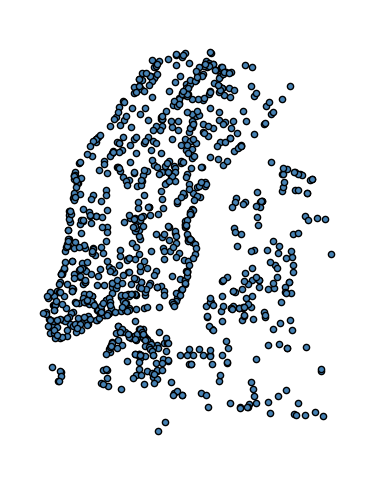

In [28]:
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree())

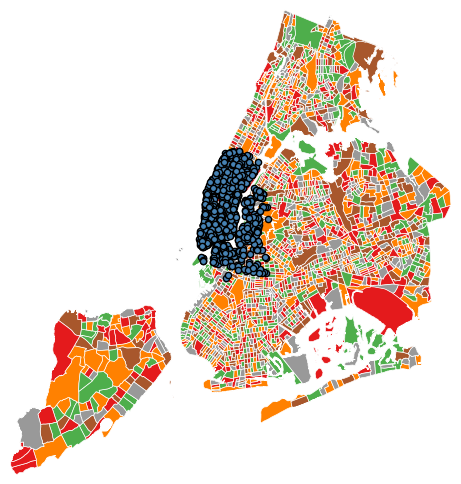

In [33]:
ax = gplt.choropleth(census_tracts, hue='mock_data', projection=ccrs.AlbersEqualArea(), edgecolor='white',
                     linewidth=0.5)
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

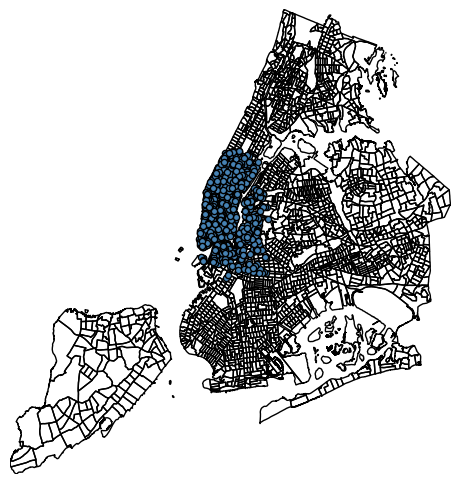

In [34]:
ax = gplt.polyplot(census_tracts, projection=ccrs.AlbersEqualArea())
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

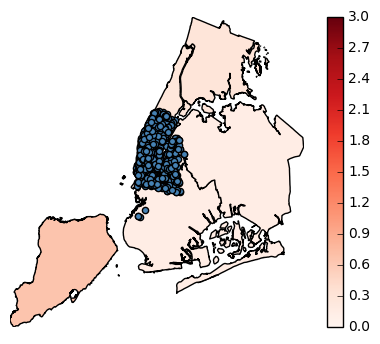

In [38]:
ax = gplt.aggplot(collisions.head(100), projection=ccrs.AlbersEqualArea(), hue='NUMBER OF PERSONS INJURED', cmap='Reds',
             geometry=boroughs, by='BOROUGH')
gplt.pointplot(gpd.GeoDataFrame(geometry=to_and_from['To']), projection=ccrs.PlateCarree(), 
               ax=ax, zorder=10)

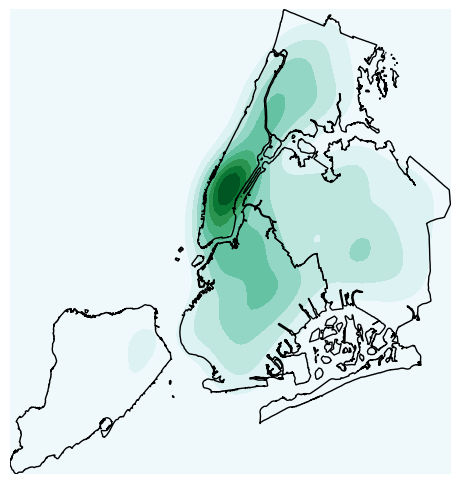

In [48]:
ax = gplt.kdeplot(collisions, projection=ccrs.AlbersEqualArea(), shade=True)
gplt.polyplot(boroughs, projection=ccrs.AlbersEqualArea(), ax=ax)

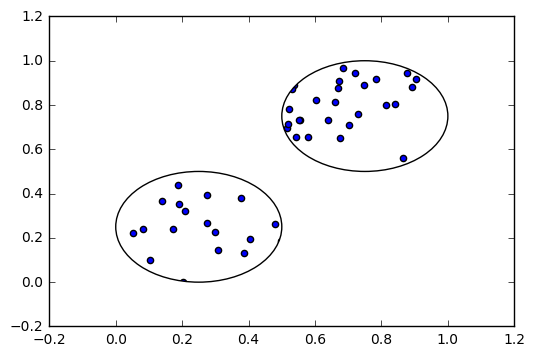

In [61]:
import matplotlib.patches as patches

np.random.seed(101)
x = np.random.random(100)
y = np.random.random(100)

fig = plt.figure()
ax = fig.add_subplot(111)
imForEngland = ax.scatter(x,y)
imForWales = ax.scatter(x,y)
england = patches.Circle((.75,.75),radius=.25,fc='none')
wales = patches.Circle((.25,.25),radius=.25,fc='none')
ax.add_patch(england)
ax.add_patch(wales)
imForEngland.set_clip_path(england)
imForWales.set_clip_path(wales)

In [23]:
%ls

cartopy-projections.ipynb       quad.ipynb
dev-1.ipynb                     runtime-failure-two.ipynb
dev-2.ipynb                     runtime-failure.ipynb
extents-issue.ipynb             stack-images.ipynb
generate-example-images.ipynb   test.png
matplotlib-native-output.ipynb  tutorial/


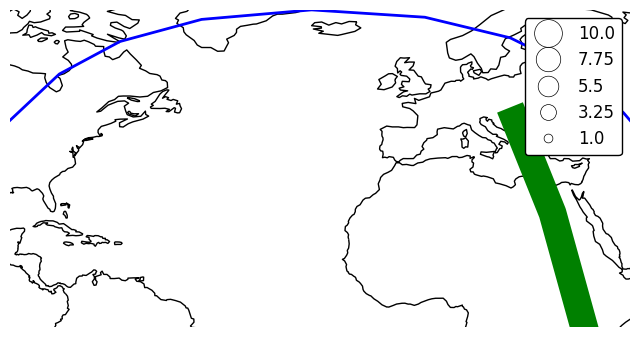

In [22]:
ax = gplt.sankey(start=gpd.GeoSeries([Point(-90, 45), Point(20, 45)]),
            end=gpd.GeoSeries([Point(45, 45), Point(35, 0)]),
            projection=ccrs.PlateCarree(),
            scale=[1, 10],
            limits=(2, 20),
            legend=True)
ax.coastlines()
plt.savefig('test.png')

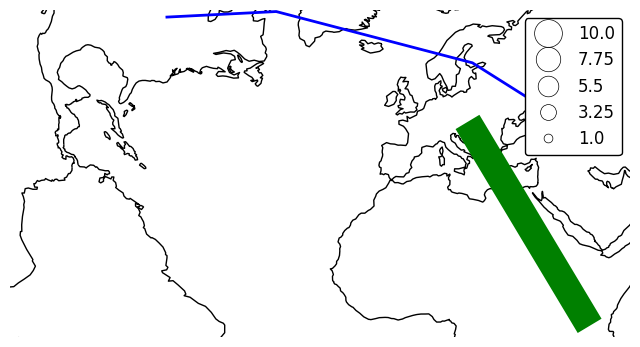

In [24]:
ax = gplt.sankey(start=gpd.GeoSeries([Point(-90, 45), Point(20, 45)]),
            end=gpd.GeoSeries([Point(45, 45), Point(35, 0)]),
            projection=ccrs.AlbersEqualArea(),
            scale=[1, 10],
            limits=(2, 20),
            legend=True)
ax.coastlines()
plt.savefig('test.png')